# Why Infinite Basis Functions?
Mark van der Wilk, Spring 2021, Probabilistic Inference, Imperial College London

Last time we looked at how bad priors can cause bad predictions, and argued
that an infinite number of basis functions would be a good ideal. Let's delve
into that a bit deeper.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
from tools import datasets
from tools import plotting
from tools.lmflow import SinusoidalBasisKernel, SqExpBasisFunctionKernel, LMR
from tools.misc import sample_prior

save_figures_location = "/Users/markvdw/Documents/teaching/probabilistic-inference/2021/slides/figures/gp/"
savefig = lambda fig, fn: fig.savefig(f"{save_figures_location}{fn}") if savefig is not None else None

raw_d = datasets.load_data("05-temperature.mat")
raw_d = raw_d.normalise(0, 1, raw_d.Y.mean(), raw_d.Y.std())
slice = np.r_[50:55, 145:250]
ld = raw_d.subset(slice)
gap_d = raw_d.subset(np.s_[55:145])

pX = np.linspace(ld.X.min() - 0.8, ld.X.max() + 0.8, 500)[:, None]

## Uncertainty and Finite Basis Functions
Last time, we already saw a reason to have lots of basis functions: without a
basis function in a location, we cannot be uncertain about its function value.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


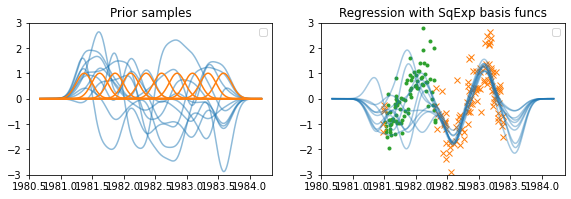

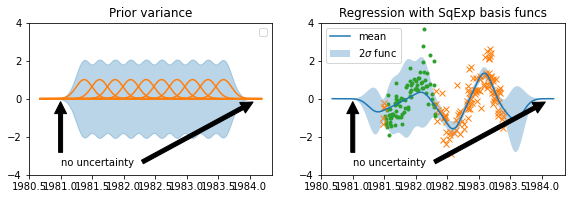

In [2]:
m = LMR((ld.X, ld.Y), SqExpBasisFunctionKernel(10, (ld.X.min() - 0.1, ld.X.max() + 0.2)))
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
samples = sample_prior(m.kernel, pX)

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(9.6, 2.8))
plt.plot(gap_d.X, gap_d.Y, '.', color='C2')
plotting.plot_1d_model(m, plot_samples=True, plot_mean=False, plot_var=False, ax=ax, pX=pX)
ax.set_ylim(-3, 3); ax.legend()
ax.set_title("Regression with SqExp basis funcs")

ax2.plot(pX, samples, color='C0', alpha=0.5)
ax2.plot(pX, m.kernel.Phi(pX), color='C1')
ax2.set_title("Prior samples")
ax2.set_ylim(-3, 3); ax2.legend()
savefig(fig, f"regression_basisfunc_prior_post_samples.pdf")

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(9.6, 2.8))
plt.plot(gap_d.X, gap_d.Y, '.', color='C2')
plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var='f', ax=ax, pX=pX)
ax.annotate('no uncertainty', xy=(1981, 0.0), xytext=(1981, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(1984.15, 0.0), xytext=(1982.2, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_ylim(-4, 4); ax.legend()
ax.set_title("Regression with SqExp basis funcs")

prior_2sigma = m.kernel.K_diag(pX).numpy().flatten() ** 0.5 * 2.0
ax2.fill_between(pX.flatten(), -prior_2sigma, prior_2sigma, color='C0', alpha=0.3)
ax2.plot(pX, m.kernel.Phi(pX), color='C1')
ax2.annotate('no uncertainty', xy=(1981, 0.0), xytext=(1981, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate('', xy=(1984.15, 0.0), xytext=(1982.2, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.set_title("Prior variance")
ax2.set_ylim(-4, 4); ax2.legend()
savefig(fig, f"regression_basisfunc_prior_post.pdf")

We can add a basis function in a location to allow ourselves flexibility in the function there:

No handles with labels found to put in legend.


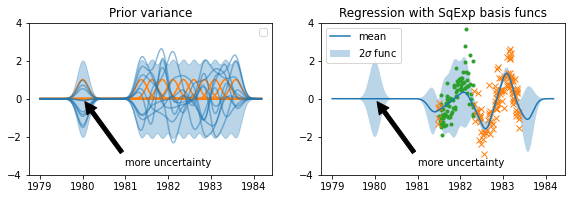

In [3]:
centres = np.hstack((np.linspace(ld.X.min() - 0.1, ld.X.max() + 0.2, 10), 1980))[:, None]
m.kernel.centres = tf.constant(centres)

pX2 = np.linspace(1979, ld.X.max() + 0.8, 500)[:, None]
samples = sample_prior(m.kernel, pX2)

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(9.6, 2.8))
plt.plot(gap_d.X, gap_d.Y, '.', color='C2')
plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var='f', ax=ax, pX=pX2)
ax.annotate('more uncertainty', xy=(1980, 0.0), xytext=(1981, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_ylim(-4, 4); ax.legend()
ax.set_title("Regression with SqExp basis funcs")

prior_2sigma = m.kernel.K_diag(pX2).numpy().flatten() ** 0.5 * 2.0
ax2.fill_between(pX2.flatten(), -prior_2sigma, prior_2sigma, color='C0', alpha=0.3)
ax2.plot(pX2, m.kernel.Phi(pX2), color='C1')
ax2.plot(pX2, samples, color='C0', alpha=0.5)
ax2.annotate('more uncertainty', xy=(1980, 0.0), xytext=(1981, -3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.set_title("Prior variance")
ax2.set_ylim(-4, 4); ax2.legend()
savefig(fig, f"regression_basisfunc_prior_post_extrabasis.pdf")

So we argued that we needed to place basis functions everywhere. This is what
this looks like:

No handles with labels found to put in legend.


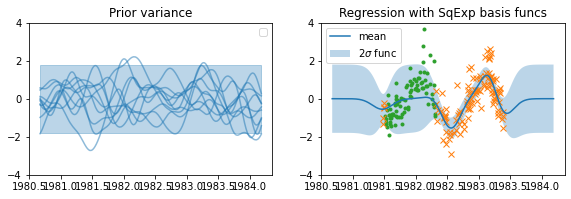

In [4]:
m = gpflow.models.GPR((ld.X, ld.Y), gpflow.kernels.SquaredExponential())
gpflow.set_trainable(m.likelihood, False)
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
samples = sample_prior(m.kernel, pX)

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(9.6, 2.8))
plt.plot(gap_d.X, gap_d.Y, '.', color='C2')
plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var='f', ax=ax, pX=pX)
ax.set_ylim(-4, 4); ax.legend()
ax.set_title("Regression with SqExp basis funcs")

prior_2sigma = m.kernel.K_diag(pX).numpy().flatten() ** 0.5 * 2.0
ax2.fill_between(pX.flatten(), -prior_2sigma, prior_2sigma, color='C0', alpha=0.3)
ax2.plot(pX, samples, color='C0', alpha=0.5)
ax2.set_title("Prior variance")
ax2.set_ylim(-4, 4); ax2.legend()
savefig(fig, f"regression_basisfunc_prior_post_infinitebasis.pdf")

## Uncertainty and Non-Local Basis Functions
But, in the polynomial basis function case, we saw large error bars far away
from the data as well, right? Can't we just use non-local basis functions?
Let's try with sinusoidal basis functions.

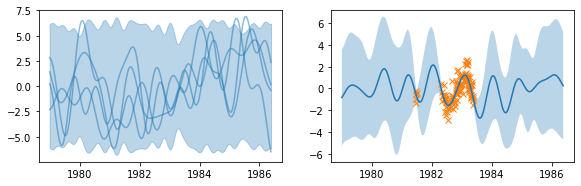

In [5]:
m = LMR((ld.X, ld.Y), SinusoidalBasisKernel(20))
m.kernel.lengthscales.assign(0.2)
gpflow.set_trainable(m.kernel.frequencies, False)
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

pX2 = np.linspace(1979, ld.X.max() + 3, 400)[:, None]
samples = sample_prior(m.kernel, pX2, 4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 2.8))
ax1.plot(pX2, samples, color='C0', alpha=0.5)
prior_2sigma = m.kernel.K_diag(pX2).numpy().flatten() ** 0.5 * 2.0
ax1.fill_between(pX2.flatten(), -prior_2sigma, prior_2sigma, color='C0', alpha=0.3)

plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var='f', ax=ax2, pX=pX2)
savefig(fig, f"regression_basisfunc_prior_post_nonlocal.pdf")

At least there's uncertainty everywhere! But also, now the uncertainty far from
the data is weirdly influenced by the data we see. That isn't great either.


## Observing More Data and Finite Basis Functions
As you observe more data, the uncertainty you have over your posterior reduces
(as the likelihood "cuts away" more of the prior). One problem with having a
finite number of basis functions, is that as you get more data the model may
end up being completely certain about the function. This is bad because:
1. it is probably not a good idea to reduce unceratinty even very far away from
   the region where you see data, and
-  the true function may not be in your prior or posterior, which limits
   predictive accuracy.

Let's visualise this.

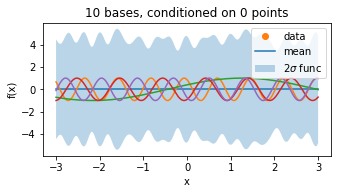

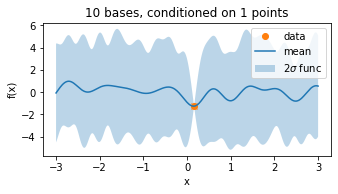

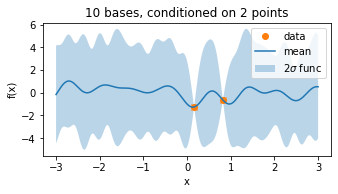

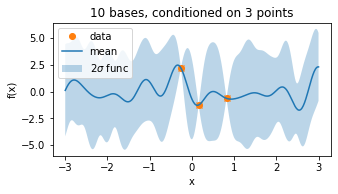

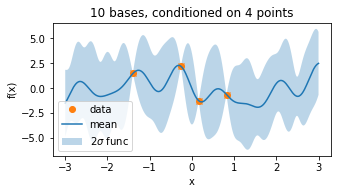

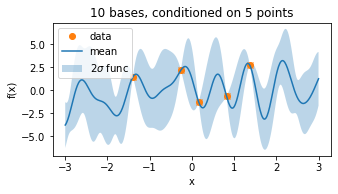

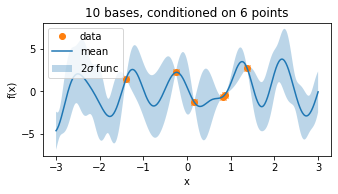

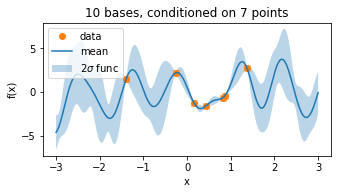

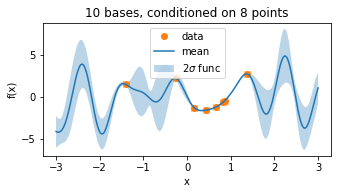

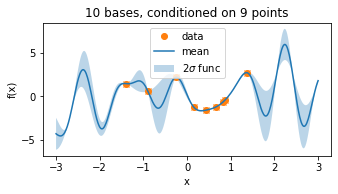

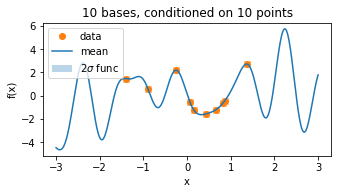

In [11]:
kern = SinusoidalBasisKernel(10)
kern.lengthscales.assign(0.2)
pX2 = np.linspace(-3.0, 3.0, 400)[:, None]
dX = np.random.randn(10, 1)
dY = sample_prior(kern, dX, 1)

for i in range(len(dX) + 1):
    m = LMR((dX[:i, :], dY[:i, :]), kern)
    m.likelihood.variance = 1e-10
    fig, ax = plt.subplots(1, 1, figsize=(4.8, 2.8), tight_layout=True)
    ax.plot(dX[:i, :], dY[:i, :], 'o', color='C1', label="data")
    plotting.plot_1d_model(m, plot_samples=False, plot_mean=True, plot_var='f', ax=ax, pX=pX2)
    if i == 0:
        ax.plot(pX2, m.kernel.Phi(pX2)[:, :4])
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.set_title(f"10 bases, conditioned on {i} points")
    ax.legend()
    # fig.set_tight_layout(True)
    savefig(fig, f"regression_basisfunc_add_data{i}.pdf")

# ax.plot(dX, dY, 'x')